In [8]:
import pandas as pd

file_path = '/Users/noraizabid/Desktop/Ethprediction1hBtc+Eth/EthBTC1h.csv'  # Update the file path to your uploaded dataset
df = pd.read_csv(file_path, index_col='time', parse_dates=['time'], dayfirst=True)
df.head()

,Btc-open,Btc-high,Btc-low,Btc-close,volume,Eth-open,Eth-high,Eth-low,Eth-close,Eth-volume
time,,,,,,,,,,
2021-06-07 01:00:00,36303.93,36812.39,36183.73,36695.07,635.595792,2764.03,2799.44,2742.41,2793.38,14683.791930
2021-06-07 02:00:00,36695.07,36774.17,36557.01,36654.50,359.147264,2793.63,2798.50,2779.04,2787.68,8295.870396
2021-06-07 03:00:00,36654.50,36733.28,36306.18,36396.12,380.483401,2787.67,2795.00,2757.00,2767.25,8010.928042
2021-06-07 04:00:00,36396.12,36571.88,36222.00,36268.91,286.839692,2767.76,2797.97,2767.28,2769.72,6219.342686
2021-06-07 05:00:00,36269.60,36446.32,36100.01,36302.78,342.457217,2769.71,2793.02,2764.30,2788.44,4927.705861


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 168, 50)           12200     
                                                                 
 dropout (Dropout)           (None, 168, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 32451 (126.76 KB)
Trainable params: 32451 (126.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
613/613

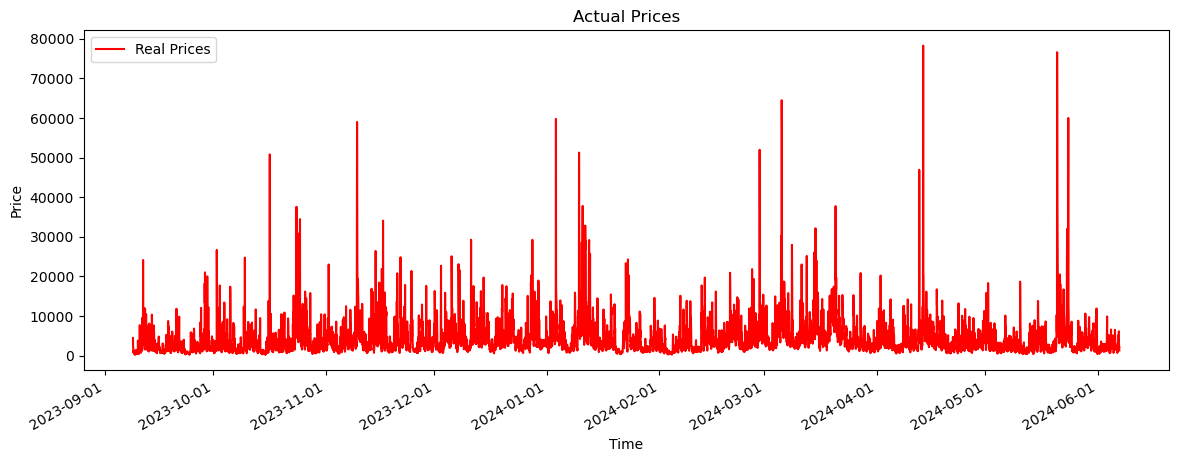

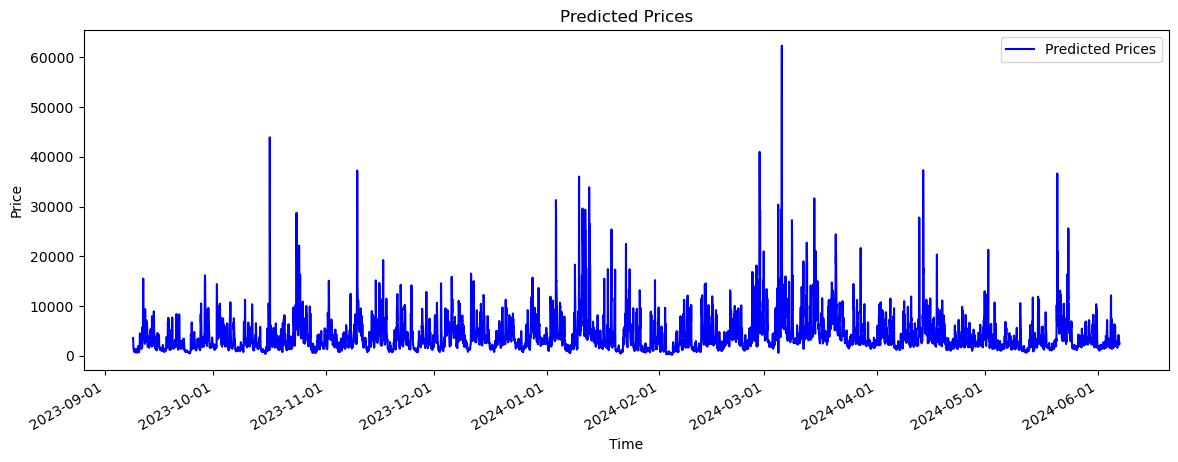

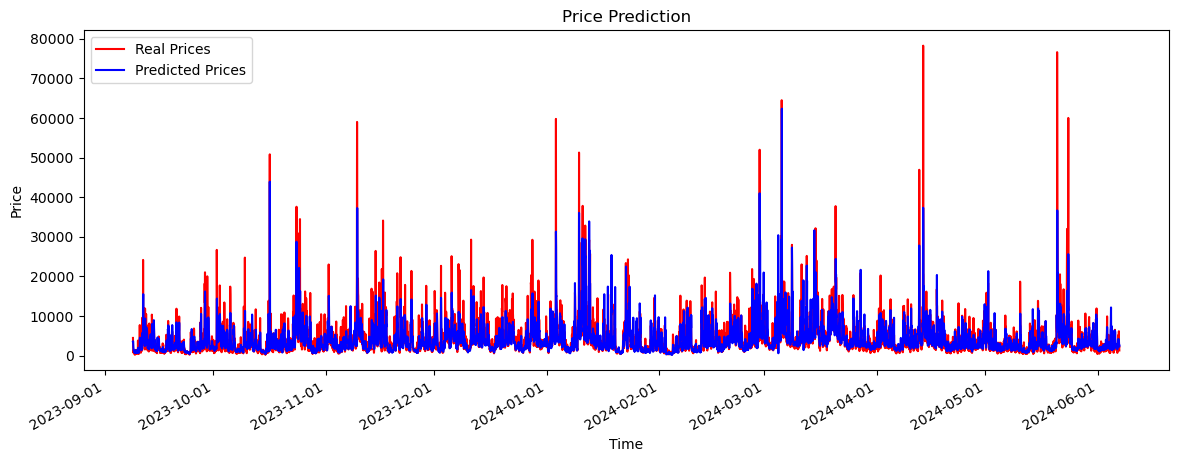

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Load the dataset
file_path = '/Users/noraizabid/Desktop/Ethprediction1hBtc+Eth/EthBTC1h.csv'  # Update the file path to your uploaded dataset
df = pd.read_csv(file_path, index_col='time', parse_dates=['time'], dayfirst=True)  # Ensure correct date parsing

# Prepare the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df.values)

# Function to create sequences
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length, 9])  # Use Eth-close as target (index 9 based on provided dataset structure)
    return np.array(X), np.array(y)

# Create sequences of 7 days (168 hours)
SEQ_LENGTH = 168
X, y = create_sequences(scaled_data, SEQ_LENGTH)

# Split into train and test sets
split_idx = int(len(X) * 0.75)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Extract the dates for the test set based on the split index
test_dates = df.index[SEQ_LENGTH + split_idx:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(SEQ_LENGTH, X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# Define early stopping callback with appropriate patience
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with increased epochs and early stopping
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Save the model in the native Keras format
model.save('lstm_model_1h_eth_btc_all_features.keras')

# Evaluate the model
train_loss = model.evaluate(X_train, y_train)
test_loss = model.evaluate(X_test, y_test)
print(f'Train Loss: {train_loss}')
print(f'Test Loss: {test_loss}')

# Make predictions
predicted_prices = model.predict(X_test)

# Create a function to reverse scaling correctly
def invert_scaling(scaled, scaler, original_data):
    # Creating an array of zeros and inserting the scaled data
    dummy_data = np.zeros((scaled.shape[0], original_data.shape[1]))
    dummy_data[:, 9] = scaled.flatten()  # Use Eth-close as target (index 9 based on provided dataset structure)
    # Reverse scaling
    inversed = scaler.inverse_transform(dummy_data)
    return inversed[:, 9]

# Invert scaling for predictions and actual values
predicted_prices = invert_scaling(predicted_prices, scaler, df.values)
real_prices = invert_scaling(y_test, scaler, df.values)

# Print some predictions and actual values
for i in range(10):
    print(f"Real Price: {real_prices[i]}, Predicted Price: {predicted_prices[i]}")

# Calculate metrics
mse = mean_squared_error(real_prices, predicted_prices)
mae = mean_absolute_error(real_prices, predicted_prices)
r2 = r2_score(real_prices, predicted_prices)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R2): {r2}')

# Visualization: Actual Prices
plt.figure(figsize=(14, 5))
plt.plot(test_dates, real_prices, color='red', label='Real Prices')
plt.title('Actual Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.show()

# Visualization: Predicted Prices
plt.figure(figsize=(14, 5))
plt.plot(test_dates, predicted_prices, color='blue', label='Predicted Prices')
plt.title('Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.show()

# Visualization: Combined Predicted vs Real Prices with Dates
plt.figure(figsize=(14, 5))
plt.plot(test_dates, real_prices, color='red', label='Real Prices')
plt.plot(test_dates, predicted_prices, color='blue', label='Predicted Prices')
plt.title('Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.show()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 168, 50)           12200     
                                                                 
 dropout_2 (Dropout)         (None, 168, 50)           0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 32451 (126.76 KB)
Trainable params: 32451 (126.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
613/6

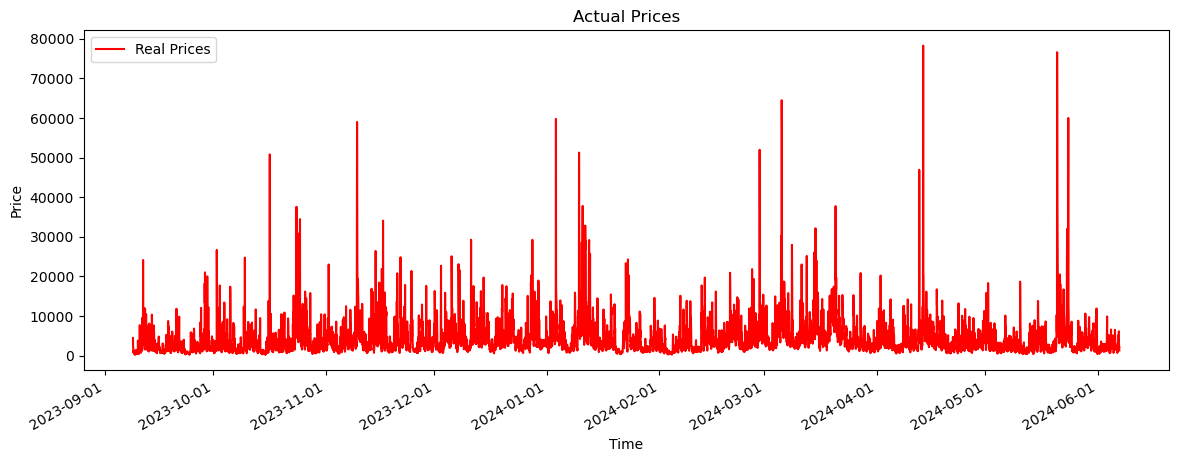

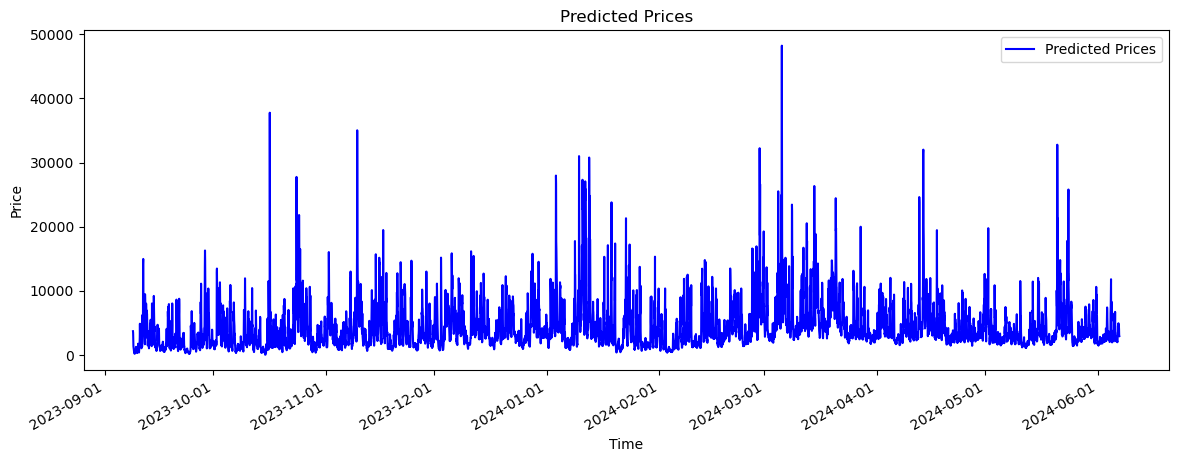

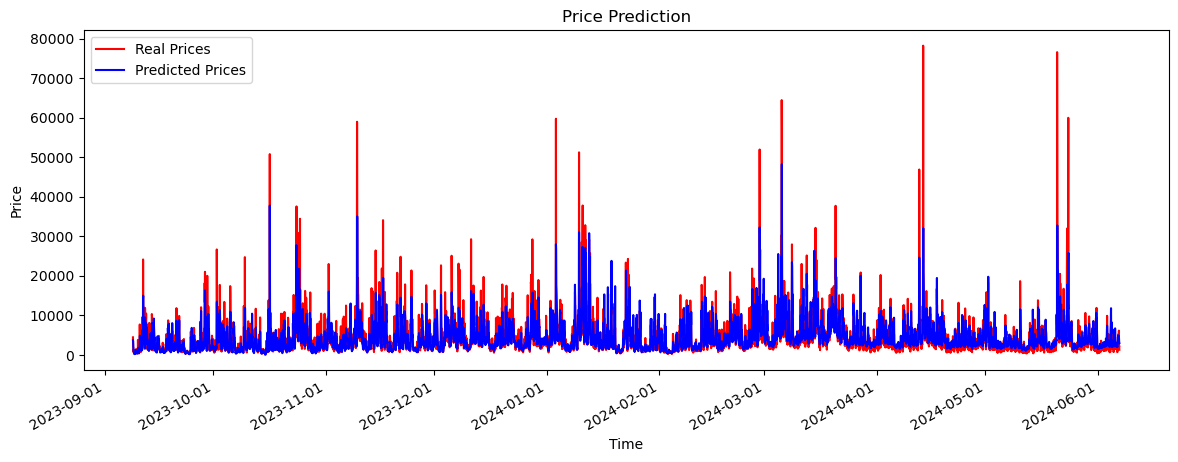

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Load the dataset
file_path = '/Users/noraizabid/Desktop/Ethprediction1hBtc+Eth/EthBTC1h.csv'  # Update the file path to your uploaded dataset
df = pd.read_csv(file_path, index_col='time', parse_dates=['time'], dayfirst=True)  # Ensure correct date parsing

# Ensure the dataset is sorted by time
df = df.sort_index()

# Prepare the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df.values)

# Function to create sequences
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length, 9])  # Use Eth-close as target (index 9 based on provided dataset structure)
    return np.array(X), np.array(y)

# Create sequences of 7 days (168 hours)
SEQ_LENGTH = 168
X, y = create_sequences(scaled_data, SEQ_LENGTH)

# Split into train and test sets
split_idx = int(len(X) * 0.75)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Extract the dates for the test set based on the split index
test_dates = df.index[SEQ_LENGTH + split_idx:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(SEQ_LENGTH, X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# Define early stopping callback with appropriate patience
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with increased epochs and early stopping
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Save the model in the native Keras format
model.save('lstm_model_1h_eth_btc_all_features.keras')

# Evaluate the model
train_loss = model.evaluate(X_train, y_train)
test_loss = model.evaluate(X_test, y_test)
print(f'Train Loss: {train_loss}')
print(f'Test Loss: {test_loss}')

# Make predictions
predicted_prices = model.predict(X_test)

# Create a function to reverse scaling correctly
def invert_scaling(scaled, scaler, original_data):
    # Creating an array of zeros and inserting the scaled data
    dummy_data = np.zeros((scaled.shape[0], original_data.shape[1]))
    dummy_data[:, 9] = scaled.flatten()  # Use Eth-close as target (index 9 based on provided dataset structure)
    # Reverse scaling
    inversed = scaler.inverse_transform(dummy_data)
    return inversed[:, 9]

# Invert scaling for predictions and actual values
predicted_prices = invert_scaling(predicted_prices, scaler, df.values)
real_prices = invert_scaling(y_test, scaler, df.values)

# Print some predictions and actual values
for i in range(10):
    print(f"Real Price: {real_prices[i]}, Predicted Price: {predicted_prices[i]}")

# Calculate metrics
mse = mean_squared_error(real_prices, predicted_prices)
mae = mean_absolute_error(real_prices, predicted_prices)
r2 = r2_score(real_prices, predicted_prices)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R2): {r2}')

# Visualization: Actual Prices
plt.figure(figsize=(14, 5))
plt.plot(test_dates, real_prices, color='red', label='Real Prices')
plt.title('Actual Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.show()

# Visualization: Predicted Prices
plt.figure(figsize=(14, 5))
plt.plot(test_dates, predicted_prices, color='blue', label='Predicted Prices')
plt.title('Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.show()

# Visualization: Combined Predicted vs Real Prices with Dates
plt.figure(figsize=(14, 5))
plt.plot(test_dates, real_prices, color='red', label='Real Prices')
plt.plot(test_dates, predicted_prices, color='blue', label='Predicted Prices')
plt.title('Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.show()


Reloading Tuner from keras_tuner_dir/lstm_hyperparameter_tuning/tuner0.json

The hyperparameter search is complete. The optimal number of units in the first LSTM layer is 32 and the optimal dropout rate is 0.30000000000000004.

Epoch 1/50
22/22 [==============================] - 2s 57ms/step - loss: 0.0236 - val_loss: 0.0082
Epoch 2/50
22/22 [==============================] - 1s 40ms/step - loss: 0.0092 - val_loss: 0.0164
Epoch 3/50
22/22 [==============================] - 1s 40ms/step - loss: 0.0073 - val_loss: 0.0162
Epoch 4/50
22/22 [==============================] - 1s 40ms/step - loss: 0.0048 - val_loss: 0.0398
Epoch 5/50
22/22 [==============================] - 1s 41ms/step - loss: 0.0060 - val_loss: 0.0188
Epoch 6/50
22/22 [==============================] - 1s 42ms/step - loss: 0.0052 - val_loss: 0.0080
Epoch 7/50
22/22 [==============================] - 1s 50ms/step - loss: 0.0050 - val_loss: 0.0068
Epoch 8/50
22/22 [==============================] - 1s 45ms/step - loss: 0.0045

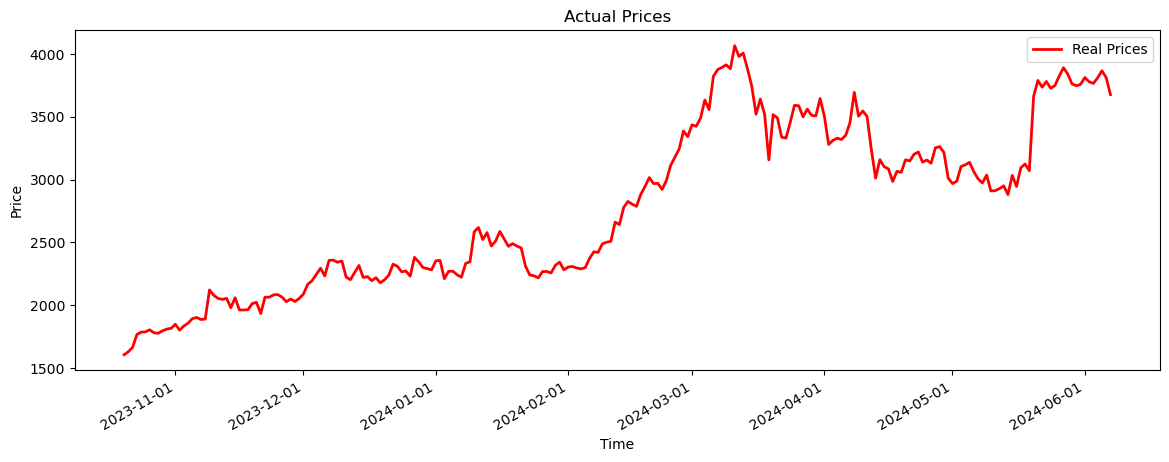

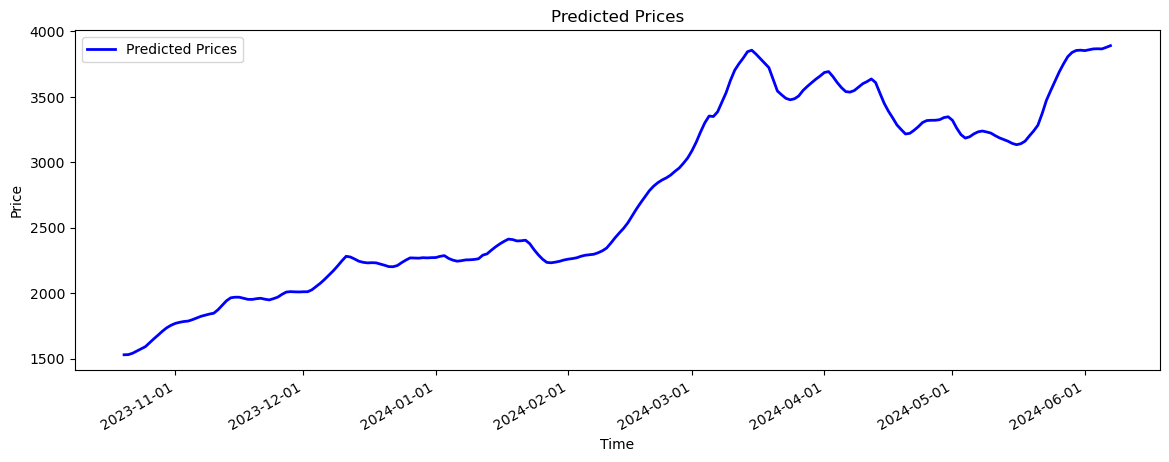

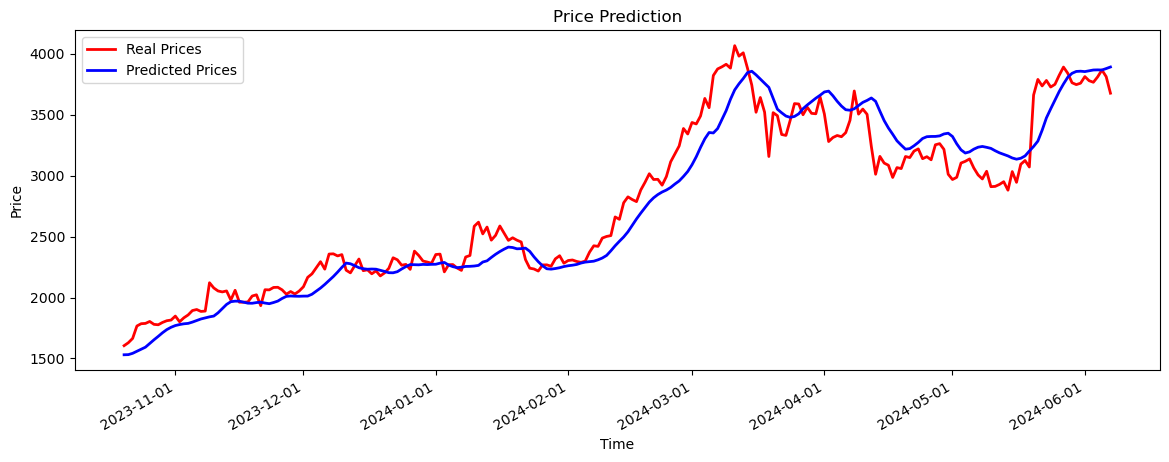

In [27]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import keras_tuner as kt

# Load the dataset
file_path = '/Users/noraizabid/Desktop/EthPrediction1DayBTC+ETH/BTCETH_1D_2024_to_2024.csv'  # Update the file path to your uploaded dataset
df = pd.read_csv(file_path, index_col='time', parse_dates=['time'], dayfirst=True)  # Ensure correct date parsing

# Prepare the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df.values)

# Function to create sequences
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length, 9])  # Use Eth-close as target (index 9 based on provided dataset structure)
    return np.array(X), np.array(y)

# Create sequences of 7 days (168 hours)
SEQ_LENGTH = 168
X, y = create_sequences(scaled_data, SEQ_LENGTH)

# Split into train and test sets
split_idx = int(len(X) * 0.75)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Extract the dates for the test set based on the split index
test_dates = df.index[SEQ_LENGTH + split_idx:]

# Define the model building function for Keras Tuner
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=256, step=32), return_sequences=True, input_shape=(SEQ_LENGTH, X_train.shape[2])))
    model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=256, step=32), return_sequences=False))
    model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(units=1))
    model.compile(optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop']), loss='mean_squared_error')
    return model

# Initialize the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='keras_tuner_dir',
    project_name='lstm_hyperparameter_tuning'
)

# Perform hyperparameter tuning
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
tuner.search(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete. The optimal number of units in the first LSTM layer is {best_hps.get('units')} and the optimal dropout rate is {best_hps.get('dropout_rate')}.
""")

# Build the model with the optimal hyperparameters and train it
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Save the best model
model.save('lstm_model_1h_eth_btc_all_features_tuned.keras')

# Evaluate the model
train_loss = model.evaluate(X_train, y_train)
test_loss = model.evaluate(X_test, y_test)
print(f'Train Loss: {train_loss}')
print(f'Test Loss: {test_loss}')

# Make predictions
predicted_prices = model.predict(X_test)

# Create a function to reverse scaling correctly
def invert_scaling(scaled, scaler, original_data):
    # Creating an array of zeros and inserting the scaled data
    dummy_data = np.zeros((scaled.shape[0], original_data.shape[1]))
    dummy_data[:, 9] = scaled.flatten()  # Use Eth-close as target (index 9 based on provided dataset structure)
    # Reverse scaling
    inversed = scaler.inverse_transform(dummy_data)
    return inversed[:, 9]

# Invert scaling for predictions and actual values
predicted_prices = invert_scaling(predicted_prices, scaler, df.values)
real_prices = invert_scaling(y_test, scaler, df.values)

# Print some predictions and actual values
for i in range(10):
    print(f"Real Price: {real_prices[i]}, Predicted Price: {predicted_prices[i]}")

# Calculate metrics
mse = mean_squared_error(real_prices, predicted_prices)
mae = mean_absolute_error(real_prices, predicted_prices)
r2 = r2_score(real_prices, predicted_prices)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R2): {r2}')

# Visualization: Actual Prices
plt.figure(figsize=(14, 5))
plt.plot(test_dates, real_prices, color='red', label='Real Prices', linestyle='-', linewidth=2)
plt.title('Actual Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.show()

# Visualization: Predicted Prices
plt.figure(figsize=(14, 5))
plt.plot(test_dates, predicted_prices, color='blue', label='Predicted Prices', linestyle='-', linewidth=2)
plt.title('Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.show()

# Visualization: Combined Predicted vs Real Prices with Dates
plt.figure(figsize=(14, 5))
plt.plot(test_dates, real_prices, color='red', label='Real Prices', linestyle='-', linewidth=2)
plt.plot(test_dates, predicted_prices, color='blue', label='Predicted Prices', linestyle='-', linewidth=2)
plt.title('Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.show()


Epoch 1/20
613/613 [==============================] - 53s 84ms/step - loss: 0.0023 - val_loss: 3.0582e-04
Epoch 2/20
613/613 [==============================] - 53s 86ms/step - loss: 9.6755e-04 - val_loss: 2.7225e-04
Epoch 3/20
613/613 [==============================] - 42s 68ms/step - loss: 7.8919e-04 - val_loss: 1.0674e-04
Epoch 4/20
613/613 [==============================] - 44s 71ms/step - loss: 6.4424e-04 - val_loss: 8.3385e-05
Epoch 5/20
613/613 [==============================] - 50s 81ms/step - loss: 5.6781e-04 - val_loss: 1.7425e-04
Epoch 6/20
613/613 [==============================] - 43s 70ms/step - loss: 5.0523e-04 - val_loss: 9.7756e-05
Epoch 7/20
613/613 [==============================] - 44s 71ms/step - loss: 4.5586e-04 - val_loss: 6.4374e-04
Epoch 8/20
613/613 [==============================] - 45s 74ms/step - loss: 4.3275e-04 - val_loss: 5.5782e-05
Epoch 9/20
613/613 [==============================] - 48s 78ms/step - loss: 4.3122e-04 - val_loss: 6.2370e-05
Epoch 10/20
61

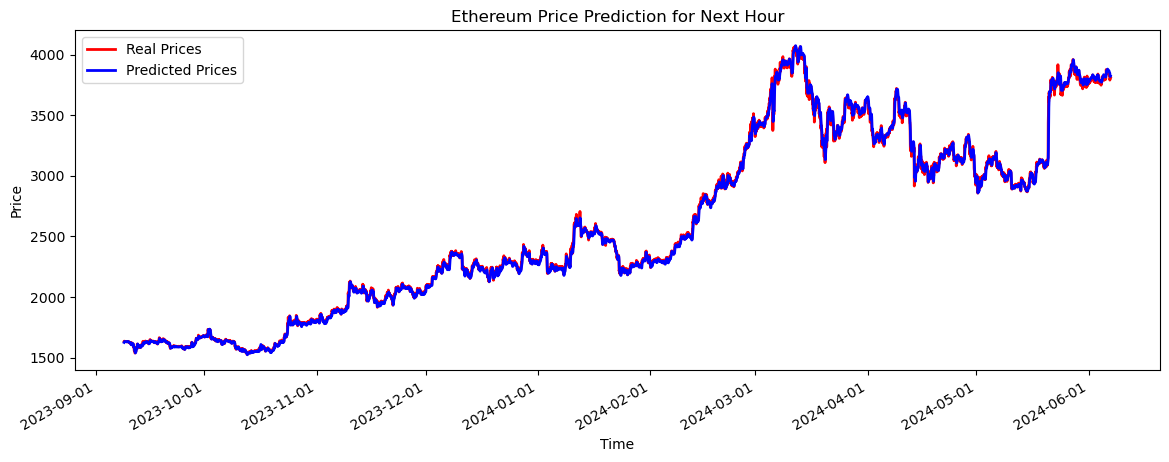

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Load the dataset
file_path = '/Users/noraizabid/Desktop/Dissertation Algos/XGboost/EthBTC1h.csv'  # Update the file path to your uploaded dataset
df = pd.read_csv(file_path, index_col='time', parse_dates=['time'], dayfirst=True)  # Ensure correct date parsing

# Ensure the dataset is sorted by time
df = df.sort_index()

# Prepare the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df.values)

# Function to create sequences for the past 7 days (168 hours)
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length, 8])  # Use Eth-close as target (index 8 based on provided dataset structure)
    return np.array(X), np.array(y)

# Create sequences using past 7 days (168 hours) to predict the next hour
SEQ_LENGTH = 168
X, y = create_sequences(scaled_data, SEQ_LENGTH)

# Split into train and test sets
split_idx = int(len(X) * 0.75)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Extract the dates for the test set based on the split index
test_dates = df.index[SEQ_LENGTH + split_idx:]

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(SEQ_LENGTH, X_train.shape[2])))  # Example: 64 units for the first LSTM layer
model.add(Dropout(rate=0.2))  # Example dropout rate
model.add(LSTM(units=64, return_sequences=False))  # Example: 64 units for the second LSTM layer
model.add(Dropout(rate=0.2))  # Example dropout rate
model.add(Dense(units=1))  # Output layer for regression
model.compile(optimizer='adam', loss='mean_squared_error')  # Using 'adam' optimizer and MSE loss

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Save the model
model.save('lstm_model_1h_eth_btc_all_features.keras')

# Evaluate the model on training data
train_loss = model.evaluate(X_train, y_train)
print(f'Train Loss (MSE): {train_loss}')

# Evaluate the model on test data
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss (MSE): {test_loss}')

# Make predictions
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# Create a function to reverse scaling correctly
def invert_scaling(scaled, scaler, original_data):
    dummy_data = np.zeros((scaled.shape[0], original_data.shape[1]))
    dummy_data[:, 8] = scaled.flatten()  # Use Eth-close as target (index 8 based on dataset structure)
    inversed = scaler.inverse_transform(dummy_data)
    return inversed[:, 8]

# Invert scaling for predictions and actual values
train_pred = invert_scaling(train_pred, scaler, df.values)
test_pred = invert_scaling(test_pred, scaler, df.values)
real_train = invert_scaling(y_train, scaler, df.values)
real_test = invert_scaling(y_test, scaler, df.values)

# Calculate metrics for training and testing
train_mse = mean_squared_error(real_train, train_pred)
test_mse = mean_squared_error(real_test, test_pred)

train_mae = mean_absolute_error(real_train, train_pred)
test_mae = mean_absolute_error(real_test, test_pred)

train_r2 = r2_score(real_train, train_pred)
test_r2 = r2_score(real_test, test_pred)

print(f'Train Mean Squared Error (MSE): {train_mse}')
print(f'Test Mean Squared Error (MSE): {test_mse}')
print(f'Train Mean Absolute Error (MAE): {train_mae}')
print(f'Test Mean Absolute Error (MAE): {test_mae}')
print(f'Train R-squared (R2): {train_r2}')
print(f'Test R-squared (R2): {test_r2}')

# Visualization: Combined Predicted vs Real Prices with Dates
plt.figure(figsize=(14, 5))
plt.plot(test_dates, real_test, color='red', label='Real Prices', linestyle='-', linewidth=2)
plt.plot(test_dates, test_pred, color='blue', label='Predicted Prices', linestyle='-', linewidth=2)
plt.title('Ethereum Price Prediction for Next Hour')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.show()
